In [1]:
import torch
from torch import nn

print(f"Using device (CPU or GPU): {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
# from src.differential_ddm import SoftBoundDDM_RT

Using device (CPU or GPU): NVIDIA GeForce RTX 4090


In [2]:
class SoftBoundDDM_RT(nn.Module):
    def __init__(self, leak=True, time_dependence=True, beta=50.0):
        super().__init__()
        # Learnable parameters
        self.ndt = nn.Parameter(torch.tensor(0.1))
        self.a = nn.Parameter(torch.tensor(2.0))
        self.z = nn.Parameter(torch.tensor(0.5))
        self.drift_gain = nn.Parameter(torch.tensor(7.0))
        self.drift_offset = nn.Parameter(torch.tensor(0.0))
        self.beta = nn.Parameter(torch.tensor(beta))

        # Fixed parameters
        self.variance = 1.0
        self.dt = 0.001
        self.leak_rate = 0.01 if leak else 0.0
        self.time_constant = 1e-2 if time_dependence else 0.0

    def forward(self, stimulus):
        n_trials, n_timepoints = stimulus.shape
        device = stimulus.device

        evidence = torch.zeros((n_trials, n_timepoints), device=device)
        dv = torch.zeros_like(evidence)

        starting_point = self.z * self.a
        urgency = torch.arange(n_timepoints, device=device) * self.time_constant
        drift_rates = self.drift_gain * stimulus + self.drift_offset
        noise = torch.randn_like(stimulus) * torch.sqrt(torch.tensor(self.variance * self.dt, device=device))

        evidence[:, 0] = starting_point
        dv[:, 0] = starting_point

        for t in range(1, n_timepoints):
            momentary_evidence = drift_rates[:, t - 1] * self.dt + noise[:, t - 1]
            leakage = self.leak_rate * (evidence[:, t - 1] - starting_point) * self.dt
            evidence[:, t] = evidence[:, t - 1] + momentary_evidence - leakage
            dv[:, t] = urgency[t] * (evidence[:, t] - starting_point) + starting_point

        # Compute soft decision hazards
        h1 = torch.sigmoid(self.beta * (dv - self.a))  # hazard of choice 1
        h0 = torch.sigmoid(self.beta * (0.0 - dv))  # hazard of choice 0
        return dv, h1, h0

    def compute_likelihood(self, stimulus, observed_choice, observed_rt):
        """
        stimulus: (n_trials, n_timepoints)
        observed_choice: (n_trials,) 0 or 1
        observed_rt: (n_trials,) in seconds
        """
        n_trials, n_timepoints = stimulus.shape
        device = stimulus.device
        dt = self.dt

        _, h1, h0 = self.forward(stimulus)

        # Convert observed RT to time index
        rt_idx = torch.clamp((observed_rt / dt).long(), max=n_timepoints - 1)

        # Compute survival probability
        survival = torch.cumprod(1 - h1 - h0 + 1e-8, dim=1)
        survival_shifted = torch.cat([torch.ones((n_trials, 1), device=device), survival[:, :-1]], dim=1)

        # Likelihood at decision time
        prob1 = h1 * survival_shifted
        prob0 = h0 * survival_shifted

        # Select observed choice
        idx = torch.arange(n_trials, device=device)
        choice_prob = torch.where(observed_choice == 1, prob1[idx, rt_idx], prob0[idx, rt_idx])

        # Negative log-likelihood
        nll = -torch.sum(torch.log(choice_prob + 1e-8))
        return nll


### Generate Synthetic data

In [3]:
# Parameters
n_trials = 100
n_timepoints = 1000
dt = 0.001

# Synthetic stimulus: small random fluctuations
stimulus = torch.randn(n_trials, n_timepoints) * 0.1

# True parameters for simulation
true_a = 2.0
true_z = 0.5
true_drift_gain = 5.0
true_ndt = 0.1

# Simulate "observed" choices and RTs (simplified example)
# Here we just take a simple threshold crossing for demonstration
dv = torch.zeros(n_trials, n_timepoints)
evidence = torch.zeros_like(dv)
starting_point = true_z * true_a
rt = torch.zeros(n_trials)
choice = torch.zeros(n_trials)

for t in range(n_timepoints):
    if t == 0:
        evidence[:, t] = starting_point
        dv[:, t] = starting_point
    else:
        drift = true_drift_gain * stimulus[:, t - 1] * dt
        noise = torch.randn(n_trials) * torch.sqrt(torch.tensor(dt))
        evidence[:, t] = evidence[:, t - 1] + drift + noise
        dv[:, t] = evidence[:, t]

        # Check boundaries
        crossed_upper = (dv[:, t] >= true_a) & (rt == 0)
        crossed_lower = (dv[:, t] <= 0) & (rt == 0)

        rt[crossed_upper | crossed_lower] = t * dt + true_ndt
        choice[crossed_upper] = 1
        choice[crossed_lower] = 0

# Clamp any missing RTs
rt[rt == 0] = n_timepoints * dt + true_ndt


### Initialize Model and Optimizer

In [4]:
from torch.optim import Adam

# Initialize model
model = SoftBoundDDM_RT(leak=True, time_dependence=True, beta=50.0)
# model = SoftBoundDDM_RT(leak=False, time_dependence=False, beta=50.0)

optimizer = Adam(model.parameters(), lr=0.01)


### Training Loop

In [ ]:
n_epochs = 200

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Compute negative log-likelihood
    loss = model.compute_likelihood(stimulus, choice, rt)

    # Backpropagate
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, NLL: {loss.item():.4f}")


Epoch 0, NLL: 1842.0675
Epoch 20, NLL: 1842.0682
Epoch 20, NLL: 1842.0682


In [ ]:
print("true_ndt:", true_ndt, "model.ndt:", model.ndt.item())
print("true_a:", true_a, "model.a:", model.a.item())
print("true_z:", true_z, "model.z:", model.z.item())
print("true_drift_gain:", true_drift_gain, "model.drift_gain:", model.drift_gain.item())

(0.1,
 Parameter containing:
 tensor(0.1000, requires_grad=True),
 2.0,
 Parameter containing:
 tensor(1.5105, requires_grad=True),
 0.5,
 Parameter containing:
 tensor(0.0902, requires_grad=True),
 5.0,
 Parameter containing:
 tensor(7., requires_grad=True))

In [17]:
model.ndt, model.a, model.z, model.drift_gain, model.drift_offset, model.beta, model.variance, model.dt, model.leak_rate, model.time_constant

(Parameter containing:
 tensor(0.1000, requires_grad=True),
 Parameter containing:
 tensor(1.5105, requires_grad=True),
 Parameter containing:
 tensor(0.0902, requires_grad=True),
 Parameter containing:
 tensor(7., requires_grad=True),
 Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor(49.5555, requires_grad=True),
 1.0,
 0.001,
 0.0,
 0.0)

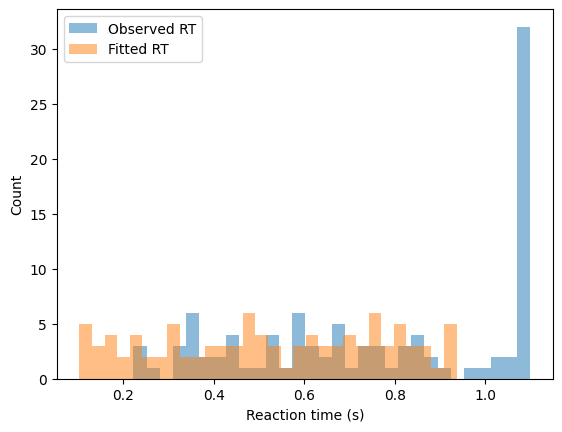

In [ ]:
import matplotlib.pyplot as plt

# Simulate with fitted model
dv_fit, h1, h0 = model.forward(stimulus)

# Predicted RT: approximate as first time step where hazard > random threshold
sim_rt = torch.zeros_like(rt)
sim_choice = torch.zeros_like(choice)
for trial in range(n_trials):
    rand_vals = torch.rand(n_timepoints)
    cumsum_hazard = torch.cumsum(h1[trial] + h0[trial], dim=0)
    idx = torch.searchsorted(cumsum_hazard, rand_vals[-1])
    idx = min(idx.item(), n_timepoints - 1)  # Clamp to valid range
    sim_rt[trial] = idx * model.dt + model.ndt
    sim_choice[trial] = 1 if h1[trial, idx] > h0[trial, idx] else 0

# Compare distributions
plt.hist(rt.numpy(), bins=30, alpha=0.5, label="Observed RT")
plt.hist(sim_rt.detach().numpy(), bins=30, alpha=0.5, label="Fitted RT")
plt.xlabel("Reaction time (s)")
plt.ylabel("Count")
plt.legend()
plt.show()


In [16]:
obs_choice_prob = choice.mean().item()
sim_choice_prob = sim_choice.mean().item()


print(f"Observed choice probability: {obs_choice_prob:.3f}")
print(f"Simulated choice probability: {sim_choice_prob:.3f}")


Observed choice probability: 0.310
Simulated choice probability: 0.000
